In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import math

In [69]:
df = pd.read_csv('neurolinguistics_study_version_2-merged.csv')

df.head()

,workerid,proliferate.condition,correct_answer,prime,probeContent,response,rt,slide_number_in_experiment,target,trial_type,...,subject_information.gender,subject_information.otherLanguage,subject_information.problems,subject_information.prolific_ID,system.Browser,system.OS,system.screenH,system.screenW,time_in_minutes,error
0,19,condition1,1,準,準,f,2195,8,腦,con,...,Female,普通话，英文,无,66d0e03800acfdbc181f1450,Chrome,Mac,900,1440,4.313183,NaN
1,19,condition1,1,輸,輸,f,2056,9,贏,sem-sem,...,Female,普通话，英文,无,66d0e03800acfdbc181f1450,Chrome,Mac,900,1440,4.313183,NaN
2,19,condition1,2,湧,敢,j,1828,10,敢,phon-sem,...,Female,普通话，英文,无,66d0e03800acfdbc181f1450,Chrome,Mac,900,1440,4.313183,NaN
3,19,condition1,2,炸,查,j,1898,11,查,con,...,Female,普通话，英文,无,66d0e03800acfdbc181f1450,Chrome,Mac,900,1440,4.313183,NaN
4,19,condition1,1,繪,繪,f,2126,12,港,con,...,Female,普通话，英文,无,66d0e03800acfdbc181f1450,Chrome,Mac,900,1440,4.313183,NaN


In [70]:
# df['workerid'].value_counts()

In [71]:
# Get all columns that start with 'subject_information.'
info_cols = [col for col in df.columns if col.startswith('subject_information.')]
keywords = ['comments', 'problems', 'assess','prolific_ID']
info_cols = [col for col in info_cols if not any(k in col for k in keywords)]

# Get unique worker IDs
subject_ids = df['workerid'].unique()

# exclude people if they only speak Cantonese or if their first language is cantonese
subject_ids = [
    wid for wid in subject_ids
    if not (
        # (df[df['workerid'] == wid]['subject_information.chinese_school_work_years_spoken'].iloc[0] == 0) or
        # (df[df['workerid'] == wid]['subject_information.chinese_school_work_years_written'].iloc[0] == 0) or 
        (df[df['workerid'] == wid]['subject_information.otherLanguage'].iloc[0] == '粤语')  or
        (df[df['workerid'] == wid]['subject_information.otherLanguage'].iloc[0] == '粵語')  or
        (df[df['workerid'] == wid]['subject_information.otherLanguage'].iloc[0][:2] == '粤语')  or
        (df[df['workerid'] == wid]['subject_information.otherLanguage'].iloc[0][:2] == '粵語')


    )
]

# # Loop over each subject and print their info
# for workerid in subject_ids:
#     df_subj = df[df['workerid'] == workerid]
#     print(f'----- workerid: {workerid} -----')
#     for col in info_cols:
#         unique_val = df_subj[col].unique()
#         print(f'{col}: {unique_val}')


In [72]:
subjects = subject_ids
n_subjects = len(subjects)

print('Total number of subjects: ', n_subjects)

Total number of subjects:  18


In [73]:
def compute_accuracy(df):

    ntrials = len(df)
    n_correct_trials = 0
    
    for ii in range(len(df)):

        trial = df.iloc[ii]
        correct_answer = trial['correct_answer']
        response = trial['response']

        if (correct_answer == 1 and response == 'f') or (correct_answer == 2 and response == 'j'):

            n_correct_trials += 1

    accuracy_percent = n_correct_trials / ntrials

    return accuracy_percent

In [74]:
def compute_rt(df, trial_type):

    df_trial_type = df[df['trial_type'] == trial_type]
    # df_trial_type = df_trial_type[df_trial_type['correct_answer'] == 1]    
    # df_trial_type = df_trial_type[df_trial_type['slide_number_in_experiment'] <=90]

    rt = df_trial_type['rt']

    rt = rt - (300 + 300 + 300 + 300)

    assert(rt > 0).all(), "Some RTs are not greater than 0"

    # # Remove outliers: RTs more than 3 SDs away from the mean
    # rt_mean = rt.mean()
    # rt_std = rt.std()

    # lower_bound = rt_mean - 3 * rt_std
    # upper_bound = rt_mean + 3 * rt_std

    # rt = rt[(rt >= lower_bound) & (rt <= upper_bound)]    
    
    return(rt.median())
    

In [75]:
# List of subject-level variables you're interested in
subject_vars = [
    'subject_information.age',
    'subject_information.gender',
    'subject_information.chinese_country_years',
    'subject_information.chinese_family_years',
    'subject_information.chinese_school_work_years_spoken',
    'subject_information.chinese_school_work_years_written'
]

results = []

for subj in range(n_subjects):
    workerid = subjects[subj]
    df_workerid = df[df['workerid'] == workerid]

    overall_accuracy = compute_accuracy(df_workerid)

    # Extract subject-level info
    subj_info = {var: df_workerid[var].iloc[0] for var in subject_vars}

    # Compute median RTs for each trial type
    med_rts = {}
    trial_types = df_workerid['trial_type'].unique()
    for trial_type in trial_types:
        med_rts[trial_type] = compute_rt(df_workerid, trial_type)

    
    # Now calculate priming effects by subtracting control RT
    control_rt = med_rts.get('con', None)

    # Only calculate if control_rt is available
    if control_rt is not None:
        prime_effect_phon_phon = -1 * (med_rts.get('phon-phon', np.nan) - control_rt)
        prime_effect_sem_sem = -1 * (med_rts.get('sem-sem', np.nan) - control_rt)
        prime_effect_phon_sem = -1 * (med_rts.get('phon-sem', np.nan) - control_rt)

        # Create a single result entry for the subject
        result_entry = {
            'workerid': workerid,
            'accuracy': overall_accuracy,
            'prime_effect_phon_phon': prime_effect_phon_phon,
            'prime_effect_sem_sem': prime_effect_sem_sem,
            'prime_effect_phon_sem': prime_effect_phon_sem
        }

        # Add subject-level info into the result entry
        result_entry.update(subj_info)

        results.append(result_entry)

# Convert the list of dictionaries into a DataFrame
results_df = pd.DataFrame(results)


In [76]:
# print(results_df)

In [77]:
results_df.columns

Index(['workerid', 'accuracy', 'prime_effect_phon_phon',
       'prime_effect_sem_sem', 'prime_effect_phon_sem',
       'subject_information.age', 'subject_information.gender',
       'subject_information.chinese_country_years',
       'subject_information.chinese_family_years',
       'subject_information.chinese_school_work_years_spoken',
       'subject_information.chinese_school_work_years_written'],
      dtype='object')

# Demographics

In [78]:
# demographics: gender and age
gender = results_df['subject_information.gender']
age = results_df['subject_information.age']

In [79]:
# count Females
count = 0
for ii in range(len(gender)):

    this_gender = gender[ii]
    if this_gender == 'Female':
        count += 1 

print('Number of females: ', count)

# calculate mean age and sd
print('Mean age: ', np.mean(age))
print('SD for age: ', np.std(age))      

Number of females:  11
Mean age:  35.22222222222222
SD for age:  8.683032979805793


# Analysis
## Histograms

In [80]:
def plot_histogram(df, variable_name, bins=20, zero_as_bin_boundary_bool=False, ax=None, bin_edges=None):

    data = df[variable_name].dropna()

    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))

    if bin_edges is not None:
        # If bin_edges provided, use them directly
        ax.hist(data, bins=bin_edges, edgecolor='black')
    else:
        # Otherwise calculate bins
        if zero_as_bin_boundary_bool:
            data_min = data.min()
            data_max = data.max()

            range_min = min(data_min, 0)
            range_max = max(data_max, 0)

            bin_width = (range_max - range_min) / bins
            temp_bin_edges = np.arange(range_min, range_max + bin_width, bin_width)

            shift = -temp_bin_edges[temp_bin_edges < 0][-1]
            temp_bin_edges = temp_bin_edges + shift

            ax.hist(data, bins=temp_bin_edges, edgecolor='black')

        else:
            ax.hist(data, bins=bins, edgecolor='black')

    ax.set_title(f'{variable_name}')
    ax.set_xlabel(variable_name)
    ax.set_ylabel('Frequency')
    if zero_as_bin_boundary_bool:
        ax.axvline(0, color='red', linestyle='--')

    if ax is None:
        plt.show()

def plot_histograms(df, variables, bins=20, zero_as_bin_boundary_bool=False, ncols=3):

    n_vars = len(variables)
    nrows = math.ceil(n_vars / ncols)  # Automatically calculate number of rows

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), sharex=True, sharey=True)

    # Make sure axes is a flat array
    axes = axes.flatten()

    # Find common bin edges if needed
    combined_data = pd.concat([df[v].dropna() for v in variables])
    
    if zero_as_bin_boundary_bool:
        data_min = combined_data.min()
        data_max = combined_data.max()

        range_min = min(data_min, 0)
        range_max = max(data_max, 0)

        bin_width = (range_max - range_min) / bins
        bin_edges = np.arange(range_min, range_max + bin_width, bin_width)

        shift = -bin_edges[bin_edges < 0][-1]
        bin_edges = bin_edges + shift
    else:
        bin_edges = None

    # Plot each variable
    for idx, variable_name in enumerate(variables):
        plot_histogram(df, variable_name, bins=bins, zero_as_bin_boundary_bool=zero_as_bin_boundary_bool, ax=axes[idx], bin_edges=bin_edges)

    # Hide any empty subplots
    for j in range(len(variables), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


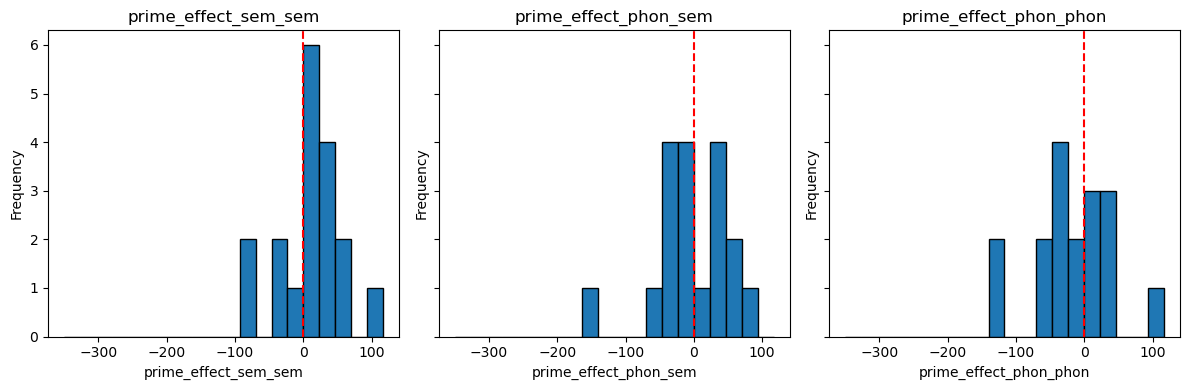

In [81]:
variables = ['prime_effect_sem_sem', 'prime_effect_phon_sem', 'prime_effect_phon_phon']

plot_histograms(results_df, variables, bins=20, zero_as_bin_boundary_bool=True)


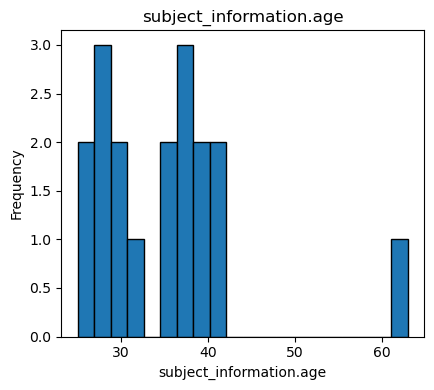

In [82]:
subject_vars = ['subject_information.age']

plot_histograms(results_df, subject_vars, bins=20, zero_as_bin_boundary_bool=False)


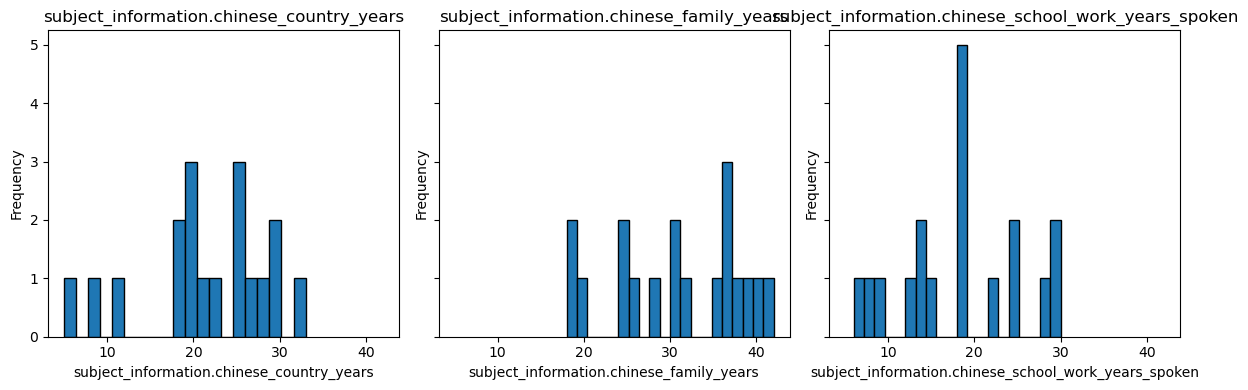

In [83]:
subject_vars = [
    'subject_information.chinese_country_years',
    'subject_information.chinese_family_years',
    'subject_information.chinese_school_work_years_spoken']

plot_histograms(results_df, subject_vars, bins=20, zero_as_bin_boundary_bool=False)


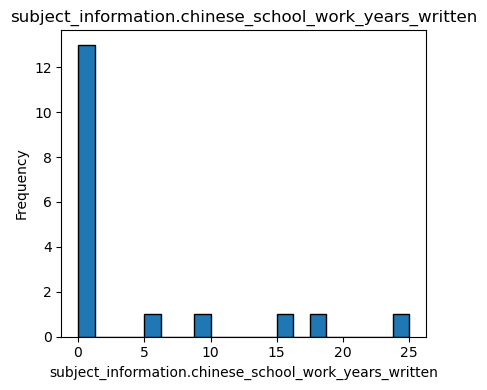

In [84]:
subject_vars = [    'subject_information.chinese_school_work_years_written']

plot_histograms(results_df, subject_vars, bins=20, zero_as_bin_boundary_bool=False)


## Scatter plots

In [85]:
def plot_scatter(df, x_var, y_var, ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))

    data = df[[x_var, y_var]].dropna()

    # Scatter plot
    ax.scatter(data[x_var], data[y_var], edgecolor='black', alpha=0.7)

    # Calculate Pearson's r and p-value
    r, p = pearsonr(data[x_var], data[y_var])

    # Set labels and title
    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)
    ax.set_title(f'r = {r:.2f}, p = {p:.3f}')

    if ax is None:
        plt.show()


def plot_multiple_scatters(df, variable_pairs, ncols=3):
    n_pairs = len(variable_pairs)
    nrows = math.ceil(n_pairs / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), sharex=True, sharey=True)

    # Make sure axes is a flat array
    axes = axes.flatten()

    # Find global x and y limits
    all_x = pd.concat([df[pair[0]].dropna() for pair in variable_pairs])
    all_y = pd.concat([df[pair[1]].dropna() for pair in variable_pairs])

    bleeding = 10
    x_min, x_max = all_x.min() - bleeding, all_x.max() + bleeding
    y_min, y_max = all_y.min() - bleeding, all_y.max() + bleeding

    # Plot each scatter
    for idx, (x_var, y_var) in enumerate(variable_pairs):
        plot_scatter(df, x_var, y_var, ax=axes[idx])

        # Set same x and y limits for all subplots
        axes[idx].set_xlim(x_min, x_max)
        axes[idx].set_ylim(y_min, y_max)

    # Hide any unused axes
    for j in range(len(variable_pairs), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


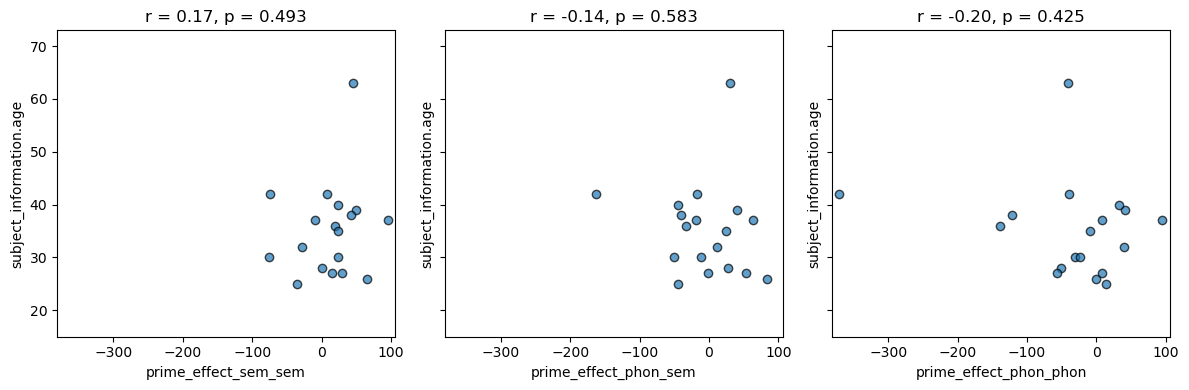

In [86]:
variable_pairs = [
    ('prime_effect_sem_sem', 'subject_information.age'),
    ('prime_effect_phon_sem', 'subject_information.age'),
    ('prime_effect_phon_phon', 'subject_information.age')
]

plot_multiple_scatters(results_df, variable_pairs, ncols=3)


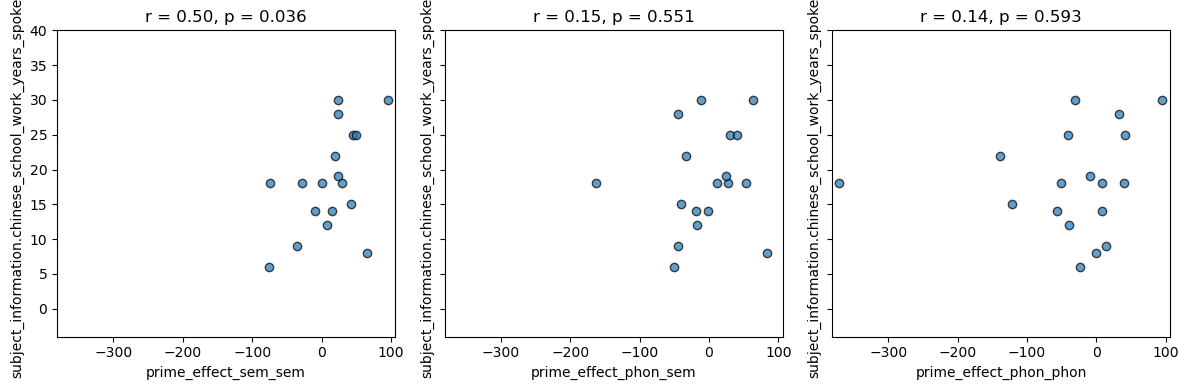

In [87]:
variable_pairs = [
    ('prime_effect_sem_sem', 'subject_information.chinese_school_work_years_spoken'),
    ('prime_effect_phon_sem', 'subject_information.chinese_school_work_years_spoken'),
    ('prime_effect_phon_phon', 'subject_information.chinese_school_work_years_spoken')
]

plot_multiple_scatters(results_df, variable_pairs, ncols=3)

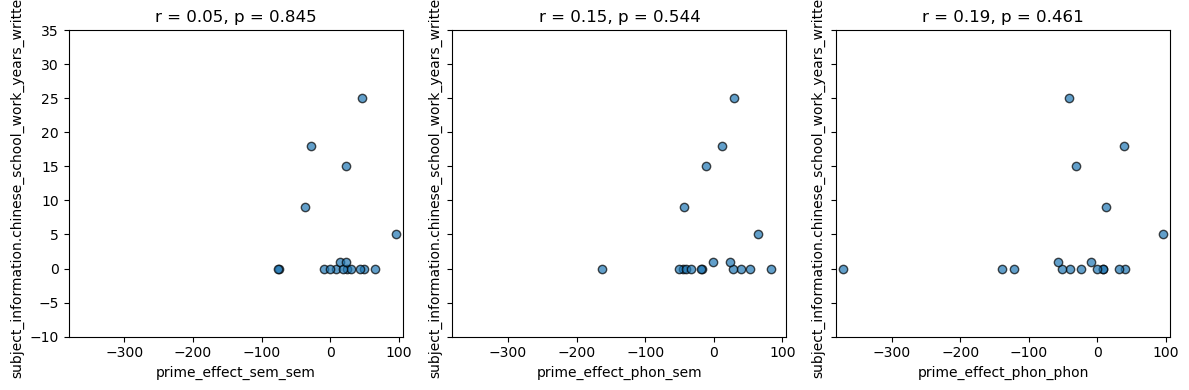

In [88]:
variable_pairs = [
    ('prime_effect_sem_sem', 'subject_information.chinese_school_work_years_written'),
    ('prime_effect_phon_sem', 'subject_information.chinese_school_work_years_written'),
    ('prime_effect_phon_phon', 'subject_information.chinese_school_work_years_written')
]

plot_multiple_scatters(results_df, variable_pairs, ncols=3)

In [89]:
def bootstrap_ci(data, n_bootstrap=1000, ci_percent=68):
    """Compute bootstrapped confidence interval for the median."""
    bootstrapped_medians = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_medians.append(np.median(sample))
    lower = np.percentile(bootstrapped_medians, (100 - ci_percent) / 2)
    upper = np.percentile(bootstrapped_medians, 100 - (100 - ci_percent) / 2)
    return lower, upper

In [90]:
def plot_priming_bar_single_df(df, variables, variable_labels=None, n_bootstrap=1000, ci_percent=68):

    # Setup labels
    if variable_labels is None:
        variable_labels = variables  # if no custom labels, just use variable names

    medians = []
    errors = []
    all_data = []

    # Process each variable
    for var in variables:
        data = df[var].dropna().to_numpy()
        all_data.append(data)

        med = np.median(data)
        medians.append(med)

        ci = bootstrap_ci(data, n_bootstrap=n_bootstrap, ci_percent=ci_percent)
        errors.append([med - ci[0], ci[1] - med])

    errors = np.array(errors).T  # shape (2, N)

    x_positions = np.arange(len(variables))

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot bars
    ax.bar(x_positions, medians, yerr=errors, capsize=5, color='lightgray', edgecolor='black', width=0.6)

    # Plot individual data points
    for idx, data in enumerate(all_data):
        ax.scatter(np.full_like(data, x_positions[idx], dtype=float) + np.random.normal(0, 0.05, size=len(data)),
                   data, alpha=0.7, edgecolor='black')

    # X-axis
    ax.set_xticks(x_positions)
    ax.set_xticklabels(variable_labels)
    ax.set_ylabel('Priming effect (ms)')
    ax.set_title('Priming Effects by Condition')

    plt.tight_layout()
    plt.show()


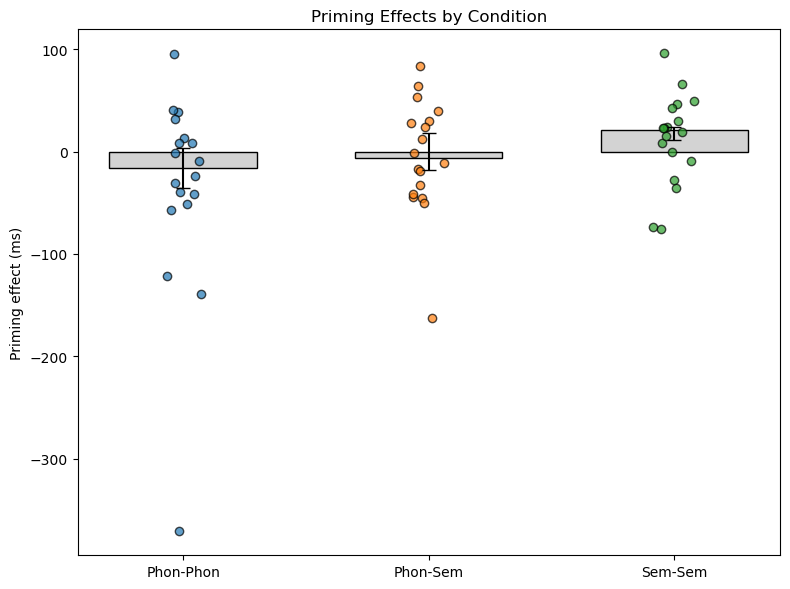

In [91]:
plot_priming_bar_single_df(
    results_df,
    variables=['prime_effect_phon_phon', 'prime_effect_phon_sem', 'prime_effect_sem_sem'],
    variable_labels=['Phon-Phon', 'Phon-Sem', 'Sem-Sem']
)


## Effect of experience with written traditional characters

In [92]:
df_written_zero = results_df[results_df['subject_information.chinese_school_work_years_written'] == 0]
df_written_positive = results_df[results_df['subject_information.chinese_school_work_years_written'] > 0]

In [93]:
def plot_priming_compare(df1, df2, variable, group_labels=('Group 1', 'Group 2'), n_bootstrap=1000, ci_percent=68):

    # Extract data
    data1 = df1[variable].dropna().to_numpy()
    data2 = df2[variable].dropna().to_numpy()

    medians = [np.median(data1), np.median(data2)]

    # Bootstrap 68% confidence intervals
    ci1 = bootstrap_ci(data1, n_bootstrap=n_bootstrap, ci_percent=ci_percent)
    ci2 = bootstrap_ci(data2, n_bootstrap=n_bootstrap, ci_percent=ci_percent)

    # Compute error bar lengths (how far above and below the median)
    errors = [
        [medians[0] - ci1[0], ci1[1] - medians[0]],
        [medians[1] - ci2[0], ci2[1] - medians[1]]
    ]
    errors = np.array(errors).T  # shape (2, 2) needed for asymmetric error bars

    x_positions = np.arange(2)

    fig, ax = plt.subplots(figsize=(6, 5))

    # Plot bars
    ax.bar(x_positions, medians, yerr=errors, capsize=5, color='lightgray', edgecolor='black', width=0.6)

    # Plot individual data points
    ax.scatter(np.full_like(data1, x_positions[0], dtype=float) + np.random.normal(0, 0.05, size=len(data1)), data1, color='blue', alpha=0.7, edgecolor='black')
    ax.scatter(np.full_like(data2, x_positions[1], dtype=float) + np.random.normal(0, 0.05, size=len(data2)), data2, color='green', alpha=0.7, edgecolor='black')

    # X-axis
    ax.set_xticks(x_positions)
    ax.set_xticklabels(group_labels)
    ax.set_ylabel(variable)
    ax.set_title(f'Median {variable}')
    ax.axhline(0, color='red', linestyle='--')

    plt.tight_layout()
    plt.show()


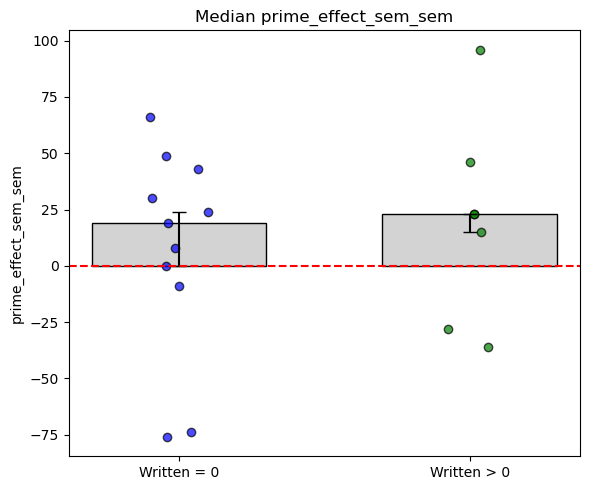

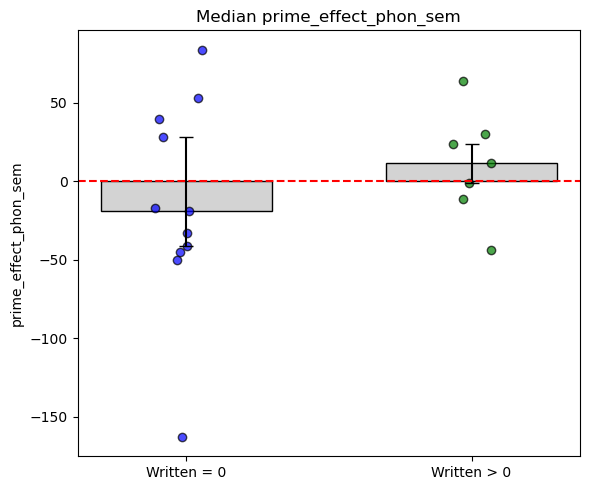

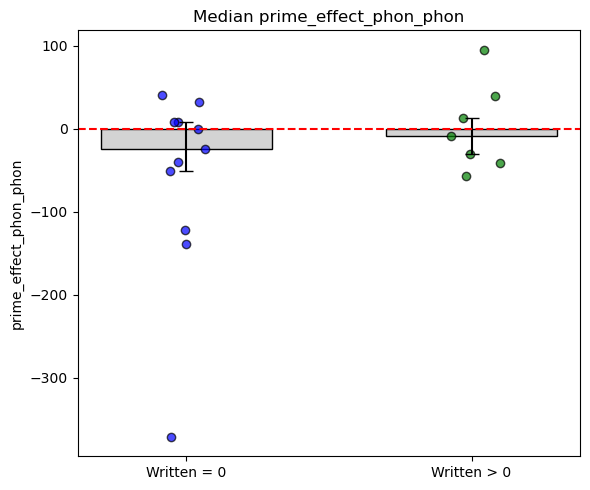

In [94]:
# Compare prime_effect_sem_sem
plot_priming_compare(df_written_zero, df_written_positive, 'prime_effect_sem_sem', group_labels=('Written = 0', 'Written > 0'))

# Compare prime_effect_phon_sem
plot_priming_compare(df_written_zero, df_written_positive, 'prime_effect_phon_sem', group_labels=('Written = 0', 'Written > 0'))

# Compare prime_effect_phon_phon
plot_priming_compare(df_written_zero, df_written_positive, 'prime_effect_phon_phon', group_labels=('Written = 0', 'Written > 0'))
